In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# 1画像だけみて、bboxからクロップして描画・保存
def show_cropped_bboxes(image_filename, train_meta, DATA_DIR, save_dir=None):
    # この画像のメタデータをフィルタリング
    bboxes = train_meta[train_meta['image_path'] == image_filename]

    # label_idでソート
    bboxes = bboxes.sort_values(by='label_id')

    if bboxes.empty:
        print(f"No metadata found for {image_filename}")
        return

    image_path = os.path.join(DATA_DIR, 'images', image_filename)
    img = cv2.imread(image_path)

    if img is None:
        print(f"Image not found: {image_path}")
        return

    # matplotlib用にBGRをRGBに変換
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    print(f"Found {len(bboxes)} bounding boxes for {image_filename}")

    plt.figure(figsize=(15, 5))

    # バウンディングボックス付きの元の画像を表示
    plt.subplot(1, len(bboxes) + 1, 1)
    img_with_box = img_rgb.copy()
    for _, row in bboxes.iterrows():
        if not pd.isna(row['x']):
            x, y, w, h = int(row['x']), int(row['y']), int(row['w']), int(row['h'])
            cv2.rectangle(img_with_box, (x, y), (x + w, y + h), (0, 255, 0), 2)
            if 'label_id' in row and not pd.isna(row['label_id']):
                 cv2.putText(img_with_box, str(int(row['label_id'])), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    plt.imshow(img_with_box)
    plt.title("Original Image with BBoxes")
    plt.axis('off')

    # クロップ画像を表示
    for i, (_, row) in enumerate(bboxes.iterrows()):
        if pd.isna(row['x']):
            continue

        x, y, w, h = int(row['x']), int(row['y']), int(row['w']), int(row['h'])

        # 座標が画像の範囲内にあることを確認
        y1 = max(0, y)
        y2 = min(img.shape[0], y + h)
        x1 = max(0, x)
        x2 = min(img.shape[1], x + w)

        crop = img_rgb[y1:y2, x1:x2]

        plt.subplot(1, len(bboxes) + 1, i + 2)
        plt.imshow(crop)
        label = int(row['label_id']) if 'label_id' in row and not pd.isna(row['label_id']) else 'N/A'
        plt.title(f"Label: {label}\n{w}x{h}")
        plt.axis('off')

    plt.tight_layout()

    # 描画結果を保存
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        base_name = os.path.splitext(image_filename)[0]
        save_path = os.path.join(save_dir, f"{base_name}_result.png")
        plt.savefig(save_path)
        print(f"Saved result to {save_path}")

    plt.show()

# 画像パスを構築する関数
def get_image_path(row):
    # Format: {quarter}__{angle}__{session:02d}__{frame:02d}.jpg
    return f"{row['quarter']}__{row['angle']}__{row['session']:02d}__{row['frame']:02d}.jpg"




Found 10 bounding boxes for Q2-008__side__00__16.jpg
Saved result to cropped_images/Q2-008__side__00__16_result.png


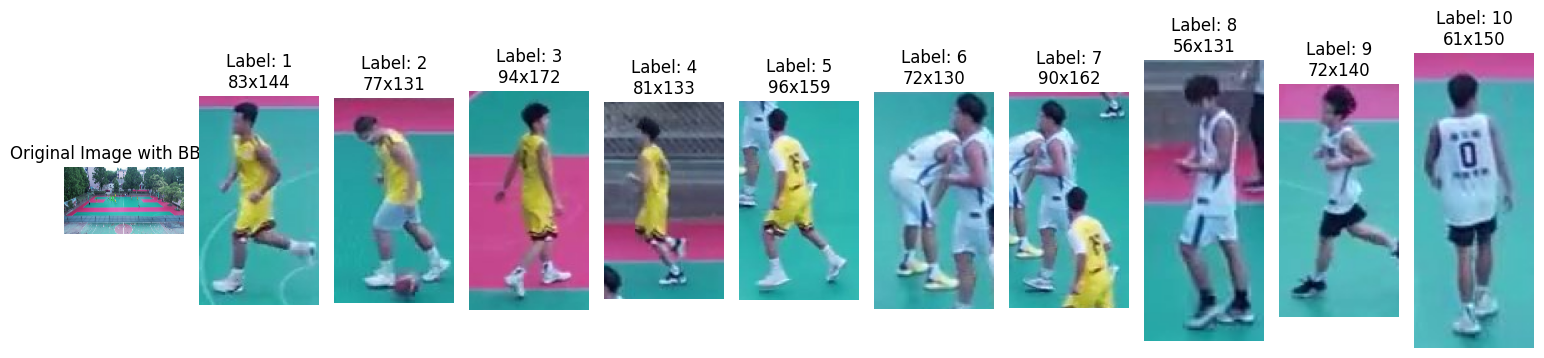

Found 10 bounding boxes for Q2-007__side__00__36.jpg
Saved result to cropped_images/Q2-007__side__00__36_result.png


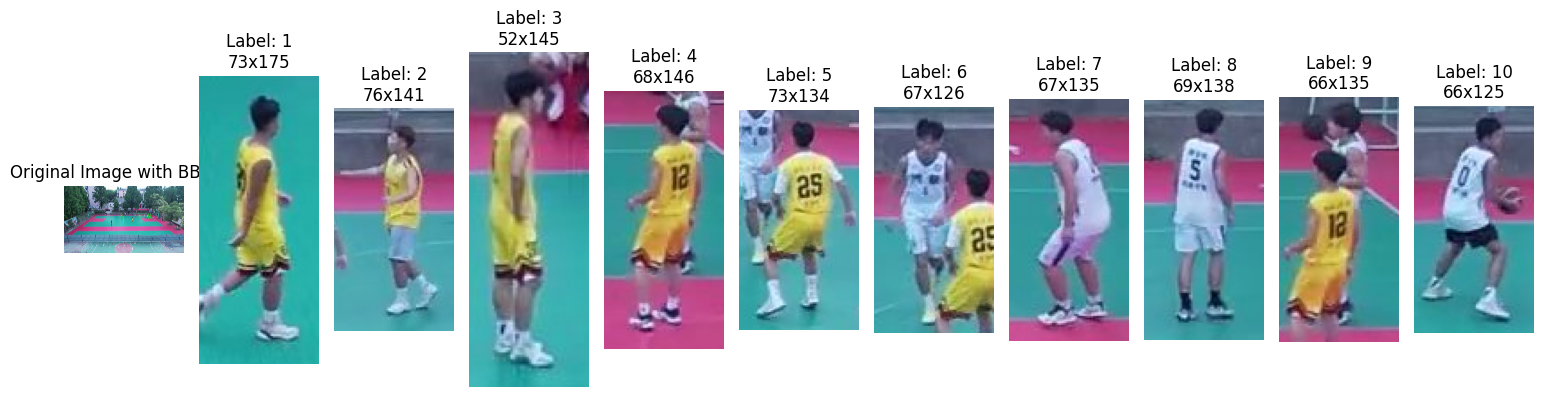

Found 10 bounding boxes for Q2-019__side__00__35.jpg
Saved result to cropped_images/Q2-019__side__00__35_result.png


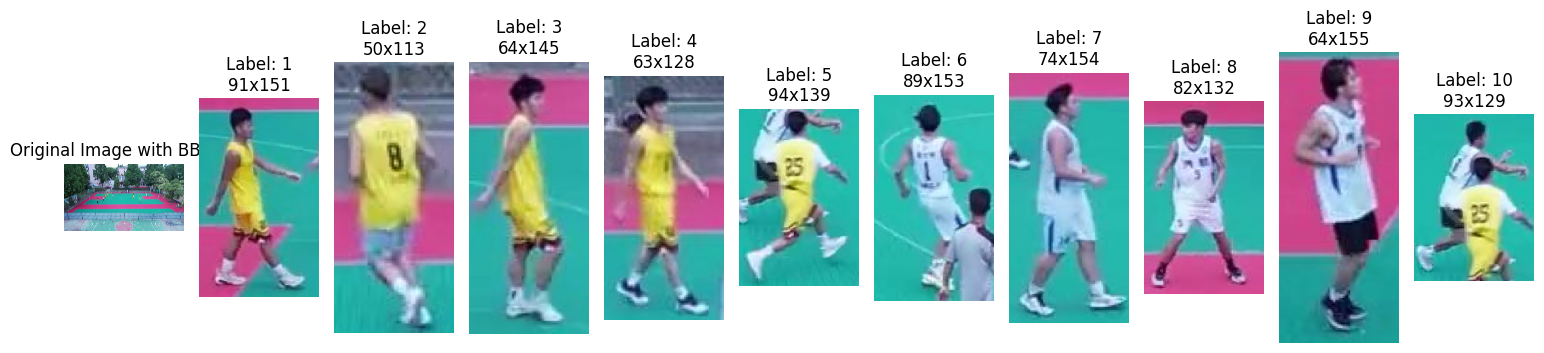

Found 10 bounding boxes for Q2-017__side__00__13.jpg
Saved result to cropped_images/Q2-017__side__00__13_result.png


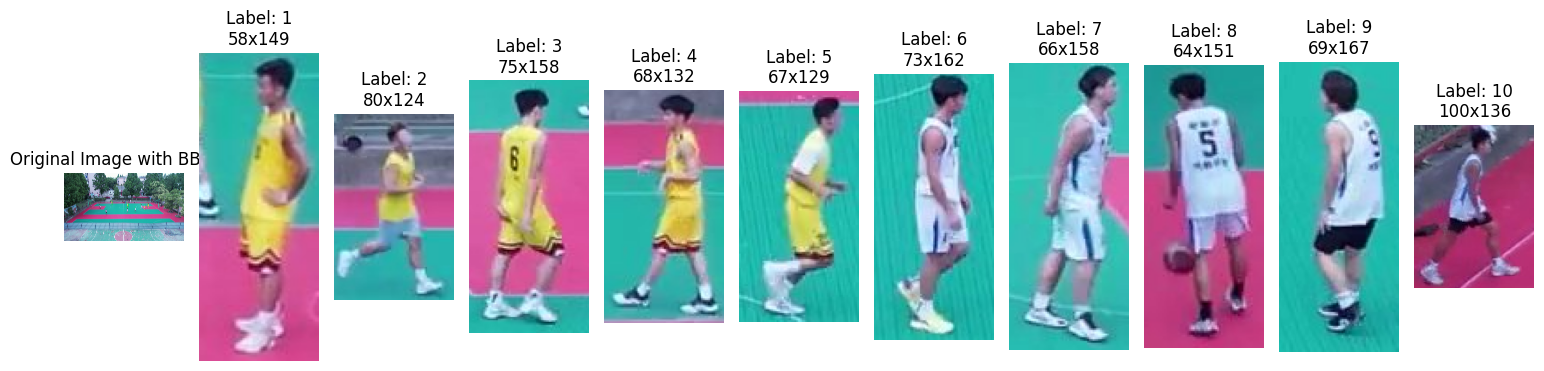

Found 10 bounding boxes for Q2-015__side__00__39.jpg
Saved result to cropped_images/Q2-015__side__00__39_result.png


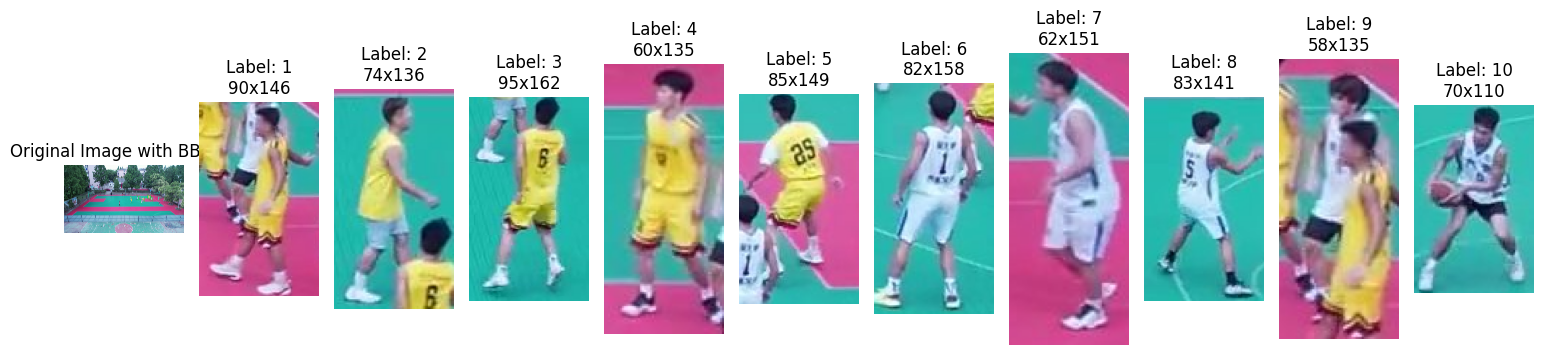

In [3]:

seed_everything()

DATA_DIR = '../inputs'
TRAIN_META_PATH = os.path.join(DATA_DIR, 'atmaCup22_2nd_meta/train_meta.csv')
train_meta = pd.read_csv(TRAIN_META_PATH)
train_meta['image_path'] = train_meta.apply(get_image_path, axis=1)

# バウンディングボックスを持つサンプル画像を選択
sample_image = train_meta[train_meta['label_id'].notna()]['image_path'].unique()

# ランダムで5画像を表示・保存
random.shuffle(sample_image)

SAVE_DIR = 'cropped_images' # 保存先ディレクトリ
for img in sample_image[:5]:
    show_cropped_bboxes(img, train_meta=train_meta, DATA_DIR=DATA_DIR, save_dir=SAVE_DIR)

In [8]:
# Load test metadata
TEST_META_PATH = os.path.join(DATA_DIR, 'atmaCup22_2nd_meta/test_meta.csv')
test_meta = pd.read_csv(TEST_META_PATH)

print(f"Test metadata shape: {test_meta.shape}")
print(f"\nTest metadata columns: {test_meta.columns.tolist()}")
print(f"\nFirst few rows:")
test_meta.head()

Test metadata shape: (9223, 9)

Test metadata columns: ['x', 'y', 'w', 'h', 'quarter', 'session_no', 'frame_in_session', 'angle', 'rel_path']

First few rows:


x     y    w    h quarter  session_no  frame_in_session angle  \
0  1366   699  137  108  Q4-000           1                 0   top   
1  1404   931  116   91  Q4-000           1                 0   top   
2  2089  1520  119  110  Q4-000           1                 0   top   
3  2532   274  137  128  Q4-000           1                 0   top   
4  2534  1241  115  135  Q4-000           1                 0   top   

                                            rel_path  
0  crops/Q4-000/sess_0001/top/Q4-000__sess0001__f...  
1  crops/Q4-000/sess_0001/top/Q4-000__sess0001__a...  
2  crops/Q4-000/sess_0001/top/Q4-000__sess0001__0...  
3  crops/Q4-000/sess_0001/top/Q4-000__sess0001__e...  
4  crops/Q4-000/sess_0001/top/Q4-000__sess0001__f...

In [9]:
# Function to display cropped images from test data
def show_test_cropped_boxes(test_meta_df, DATA_DIR, num_samples=5, seed=42):
    """
    Display cropped bounding boxes from test data using the pre-cropped images
    
    Args:
        test_meta_df: DataFrame with test metadata containing x, y, w, h, and rel_path
        DATA_DIR: Base directory path
        num_samples: Number of random samples to display
        seed: Random seed for reproducibility
    """
    np.random.seed(seed)
    
    # Sample random rows
    sample_indices = np.random.choice(len(test_meta_df), min(num_samples, len(test_meta_df)), replace=False)
    samples = test_meta_df.iloc[sample_indices]
    
    print(f"Displaying {len(samples)} cropped test images")
    
    # Calculate grid dimensions
    n_cols = 5
    n_rows = (len(samples) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 3 * n_rows))
    
    for idx, (_, row) in enumerate(samples.iterrows()):
        # Get the cropped image path
        crop_path = os.path.join(DATA_DIR, row['rel_path'])
        
        # Read the cropped image
        crop_img = cv2.imread(crop_path)
        
        if crop_img is None:
            print(f"Warning: Could not read {crop_path}")
            continue
        
        # Convert BGR to RGB
        crop_img_rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
        
        # Display the cropped image
        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(crop_img_rgb)
        
        # Add title with metadata
        title = f"{row['quarter']}\n{row['angle']}, sess_{row['session_no']}\n{row['w']}x{row['h']}"
        plt.title(title, fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return samples

Displaying 10 cropped test images


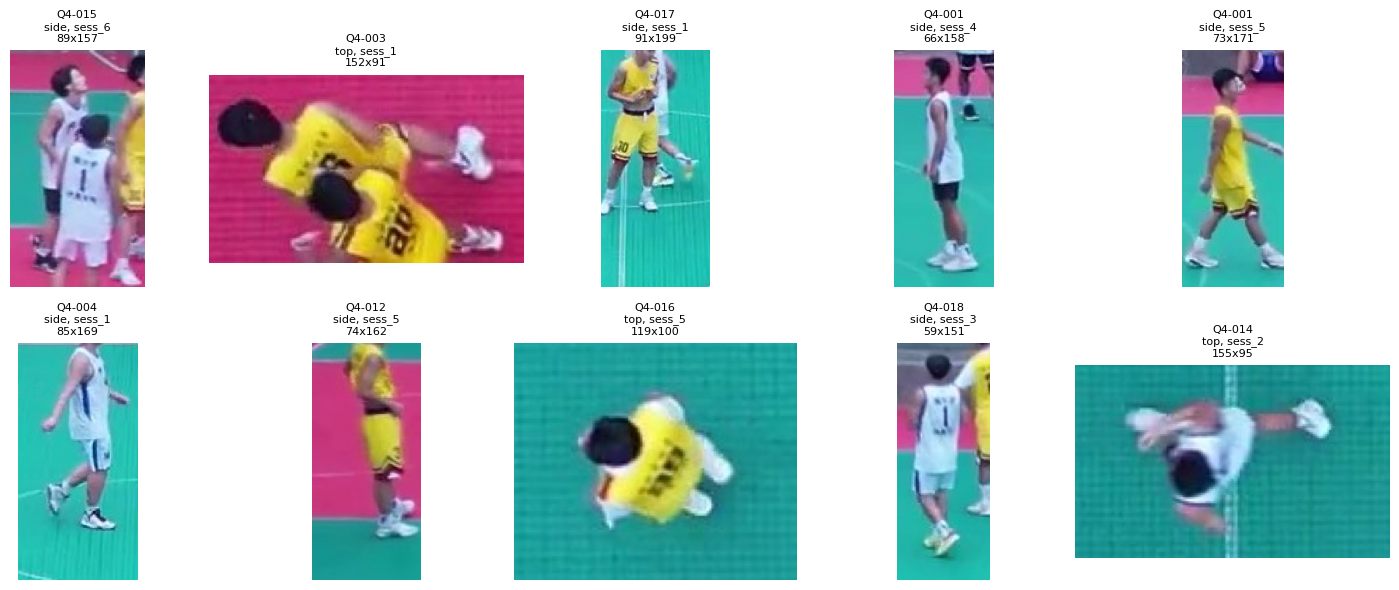

In [10]:
# Display random cropped boxes from test data
samples = show_test_cropped_boxes(test_meta, DATA_DIR, num_samples=10, seed=42)

In [11]:
# Check statistics of test data
print(f"Total test samples: {len(test_meta)}")
print(f"\nAngles distribution:")
print(test_meta['angle'].value_counts())
print(f"\nQuarters distribution:")
print(test_meta['quarter'].value_counts())
print(f"\nBbox size statistics:")
print(f"Width - mean: {test_meta['w'].mean():.2f}, std: {test_meta['w'].std():.2f}, min: {test_meta['w'].min()}, max: {test_meta['w'].max()}")
print(f"Height - mean: {test_meta['h'].mean():.2f}, std: {test_meta['h'].std():.2f}, min: {test_meta['h'].min()}, max: {test_meta['h'].max()}")

Total test samples: 9223

Angles distribution:
angle
side    6114
top     3109
Name: count, dtype: int64

Quarters distribution:
quarter
Q4-016    783
Q4-004    772
Q4-007    761
Q4-019    758
Q4-003    400
Q4-002    398
Q4-005    395
Q4-001    394
Q4-014    389
Q4-000    388
Q4-013    387
Q4-012    385
Q4-006    383
Q4-008    383
Q4-015    382
Q4-018    381
Q4-009    379
Q4-010    378
Q4-017    368
Q4-011    359
Name: count, dtype: int64

Bbox size statistics:
Width - mean: 105.66, std: 31.51, min: 45, max: 235
Height - mean: 147.96, std: 33.20, min: 16, max: 293


In [12]:
# Function to display all cropped images from the same frame
def show_crops_by_frame(test_meta_df, DATA_DIR, num_frames=3, seed=42):
    """
    Display all cropped images from the same frame_in_session grouped together
    
    Args:
        test_meta_df: DataFrame with test metadata
        DATA_DIR: Base directory path
        num_frames: Number of different frames to display
        seed: Random seed for reproducibility
    """
    np.random.seed(seed)
    
    # Get unique frame identifiers (quarter, session, frame_in_session, angle)
    test_meta_df['frame_id'] = (test_meta_df['quarter'] + '_sess' + 
                                 test_meta_df['session_no'].astype(str) + '_frame' + 
                                 test_meta_df['frame_in_session'].astype(str) + '_' + 
                                 test_meta_df['angle'])
    
    # Get counts per frame
    frame_counts = test_meta_df['frame_id'].value_counts()
    print(f"Frames with most crops: ")
    print(frame_counts.head(10))
    
    # Sample frames with multiple crops
    frames_with_multiple = frame_counts[frame_counts > 1].index.tolist()
    
    if len(frames_with_multiple) == 0:
        print("No frames with multiple crops found")
        return
    
    # Sample random frames
    selected_frames = np.random.choice(frames_with_multiple, 
                                       min(num_frames, len(frames_with_multiple)), 
                                       replace=False)
    
    for frame_id in selected_frames:
        # Get all crops from this frame
        frame_crops = test_meta_df[test_meta_df['frame_id'] == frame_id]
        
        print(f"\n{'='*80}")
        print(f"Frame: {frame_id}")
        print(f"Number of crops: {len(frame_crops)}")
        print(f"{'='*80}")
        
        # Calculate grid dimensions
        n_crops = len(frame_crops)
        n_cols = min(5, n_crops)
        n_rows = (n_crops + n_cols - 1) // n_cols
        
        plt.figure(figsize=(3 * n_cols, 3 * n_rows))
        
        for idx, (_, row) in enumerate(frame_crops.iterrows()):
            # Get the cropped image path
            crop_path = os.path.join(DATA_DIR, row['rel_path'])
            
            # Read the cropped image
            crop_img = cv2.imread(crop_path)
            
            if crop_img is None:
                print(f"Warning: Could not read {crop_path}")
                continue
            
            # Convert BGR to RGB
            crop_img_rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
            
            # Display the cropped image
            plt.subplot(n_rows, n_cols, idx + 1)
            plt.imshow(crop_img_rgb)
            
            # Add title with bbox info
            title = f"BBox {idx+1}\nPos: ({int(row['x'])}, {int(row['y'])})\nSize: {int(row['w'])}x{int(row['h'])}"
            plt.title(title, fontsize=9)
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Clean up temporary column
    test_meta_df.drop('frame_id', axis=1, inplace=True)

Frames with most crops: 
frame_id
Q4-019_sess3_frame0_top     14
Q4-006_sess6_frame1_side    14
Q4-017_sess2_frame0_side    14
Q4-016_sess5_frame3_side    14
Q4-003_sess3_frame2_top     14
Q4-017_sess1_frame1_side    14
Q4-007_sess2_frame0_side    14
Q4-016_sess5_frame4_top     14
Q4-016_sess2_frame2_top     14
Q4-002_sess3_frame2_side    14
Name: count, dtype: int64

Frame: Q4-014_sess3_frame6_top
Number of crops: 10


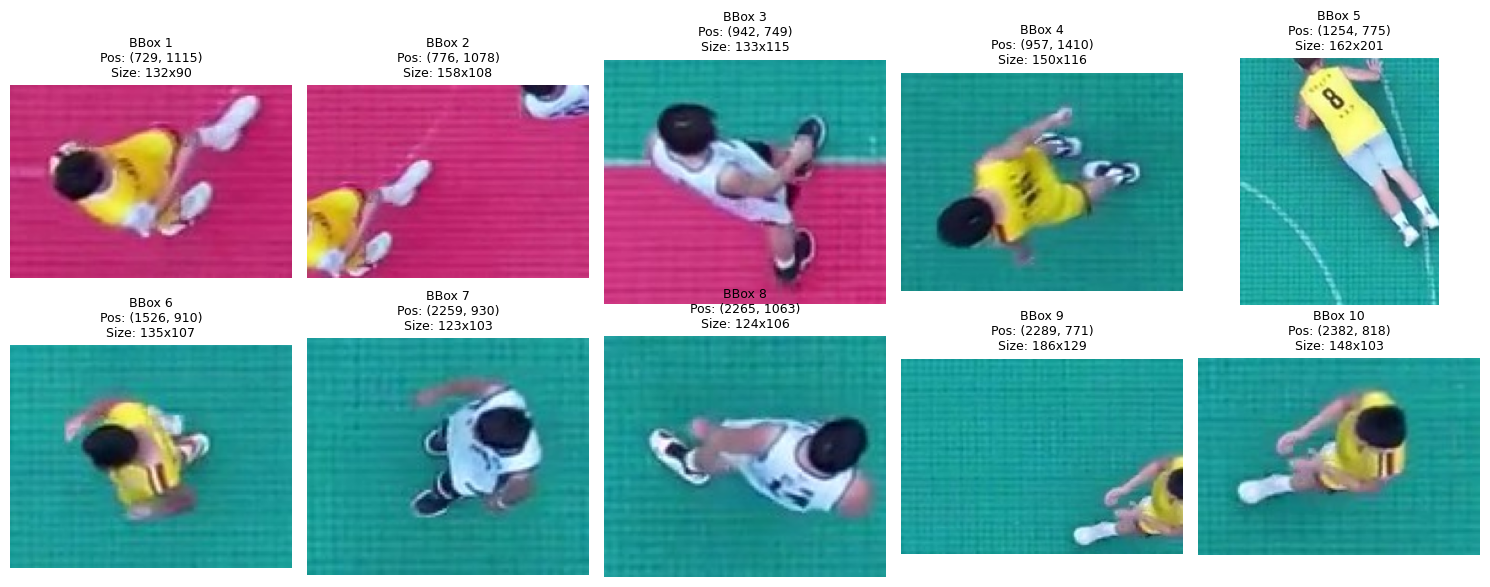


Frame: Q4-019_sess2_frame4_side
Number of crops: 9


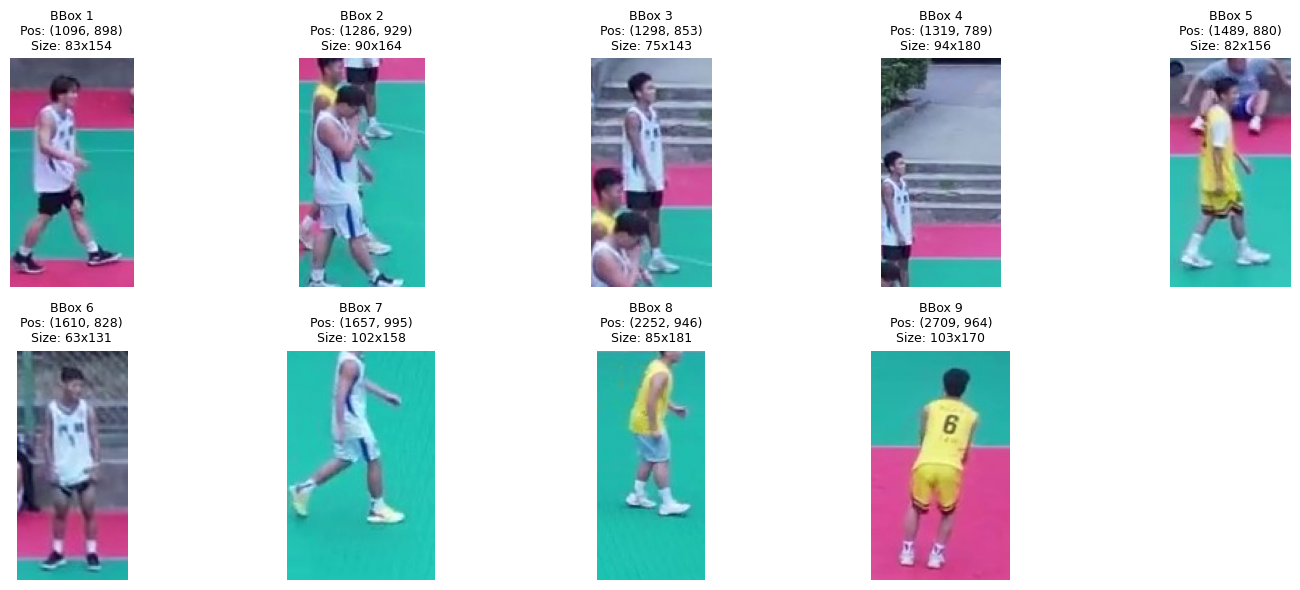


Frame: Q4-012_sess4_frame1_side
Number of crops: 12


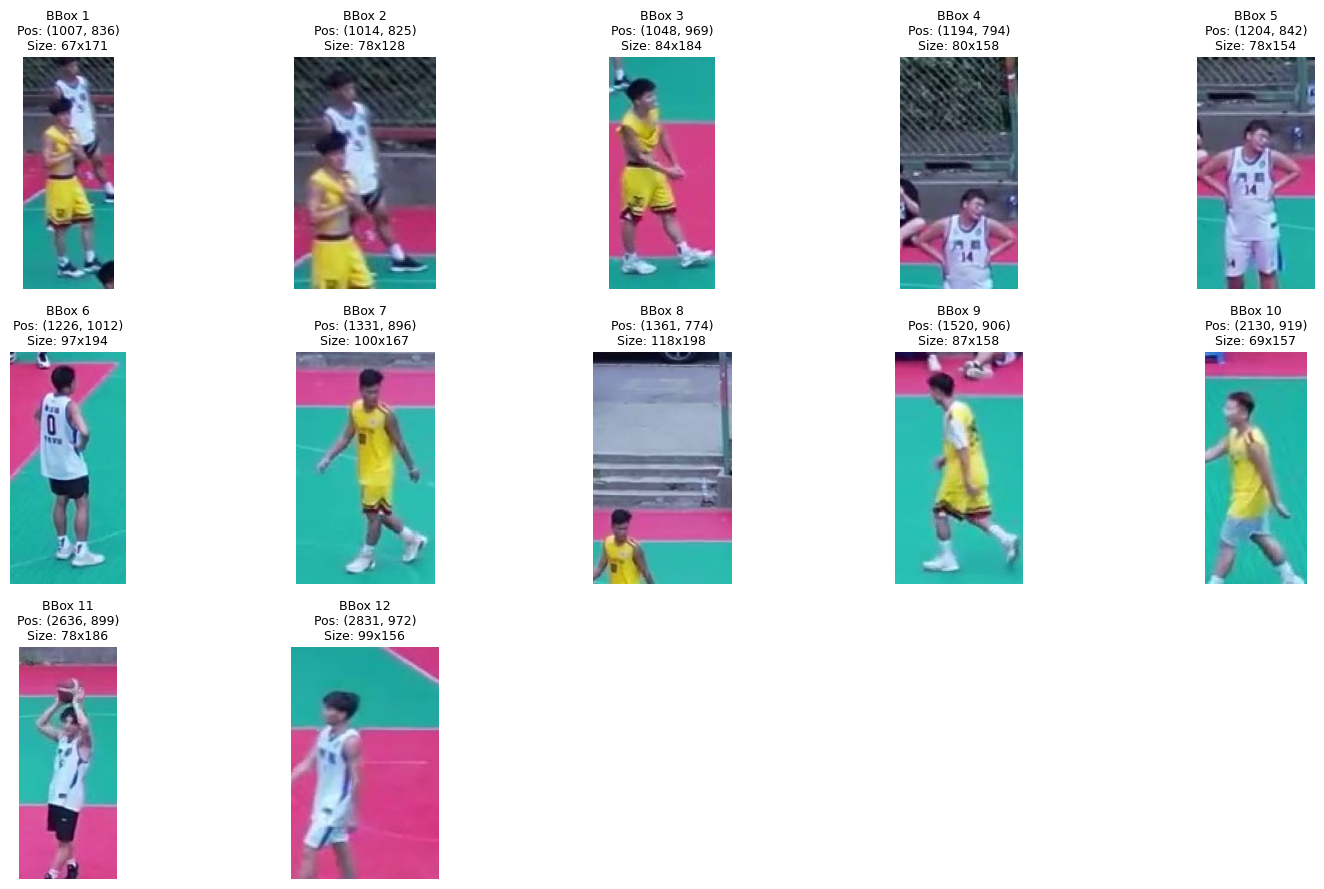


Frame: Q4-016_sess1_frame2_top
Number of crops: 9


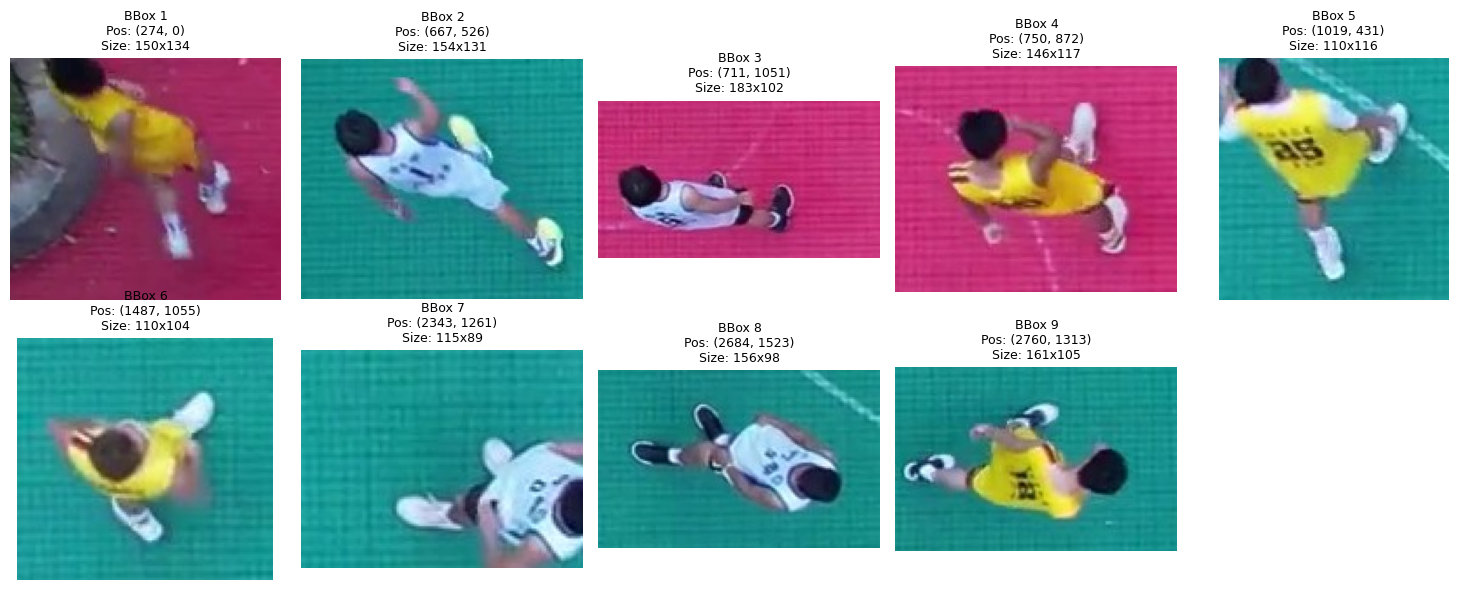


Frame: Q4-019_sess1_frame4_side
Number of crops: 12


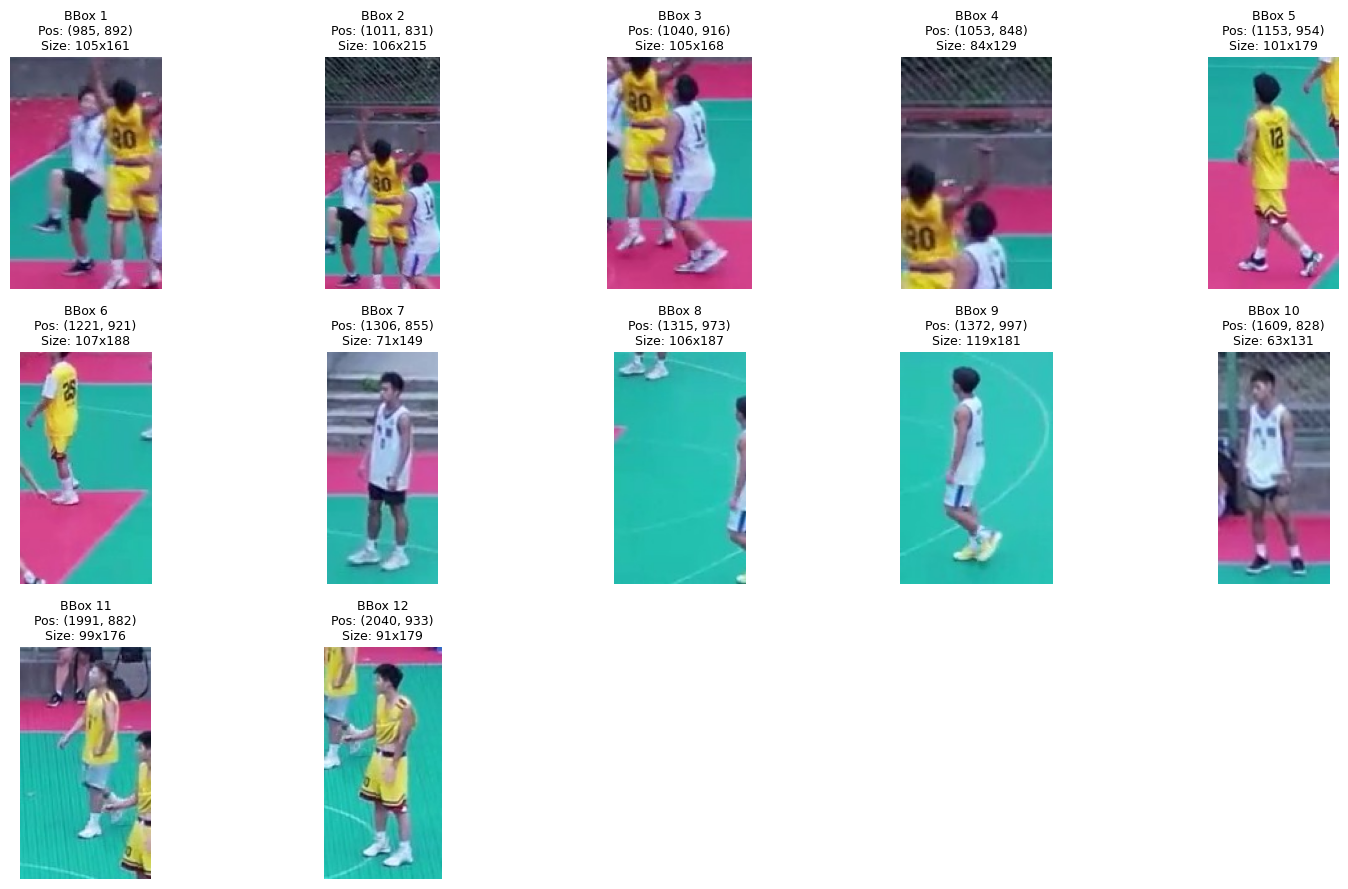

In [13]:
# Display crops grouped by frame - show 5 different frames
show_crops_by_frame(test_meta, DATA_DIR, num_frames=5, seed=42)

In [15]:
train_meta['label_id'].unique(), train_meta['label_id'].nunique()

(array([ 0,  6,  2,  1,  7,  3,  8,  4, 10,  9,  5]), 11)